# 디렉토리 설정 및 이미지데이터 전처리

In [1]:
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# 디렉토리 설정
base_dir = './0. Animal_Data/'
categories = ['cats', 'dogs', 'monkeys']
nb_classes = len(categories)

In [3]:
# 이미지 크기 지정
image_w = 256
image_h = 256
pixels = image_w*image_h*3

In [4]:
# 이미지데이터 읽어들이기
X = []
Y = []
for idx, category in enumerate(categories):
    # 레이블 지정
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    
    # 이미지
    image_dir = base_dir+category+'/*'
    files = glob.glob(image_dir)
    
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        X.append(data)
        Y.append(label)
    
X = np.array(X)
Y = np.array(Y)

# 학습 전용 데이터와 테스트 전용 데이터로 구분
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [5]:
# 데이터 정규화하기(0~1사이로)
X_train = X_train.astype("float") / 256
X_test  = X_test.astype("float")  / 256
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (5092, 256, 256, 3)
X_test shape: (1698, 256, 256, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

# 모델 구조 정의 
model = Sequential()
model.add(Conv2D(32, (3, 3), (1, 1), input_shape=X_train.shape[1:], padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), (1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), (1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# 전결합층
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [7]:
# 모델 구축하기
from tensorflow.keras import metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.CategoricalAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='categorical_accuracy', mode='max', patience=5)
mc = ModelCheckpoint(base_dir+'best_model.h5', monitor='val_categorical_accuracy', mode='max', save_best_only=True)
histroy = model.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=[es, mc], validation_split=0.15)

Train on 4328 samples, validate on 764 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4328/4328 [==============================] - 114s 26ms/sample - loss: 1.1276 - categorical_accuracy: 0.3886 - val_loss: 1.0353 - val_categorical_accuracy: 0.4948
Epoch 2/100
4328/4328 [==============================] - 98s 23ms/sample - loss: 0.9914 - categorical_accuracy: 0.4942 - val_loss: 0.9597 - val_categorical_accuracy: 0.4961
Epoch 3/100
4328/4328 [==============================] - 101s 23ms/sample - loss: 0.9357 - categorical_accuracy: 0.5492 - val_loss: 0.9077 - val_categorical_accuracy: 0.6008
Epoch 4/100
4328/4328 [==============================] - 106s 24ms/sample - loss: 0.8832 - categorical_accuracy: 0.5677 - val_loss: 0.8970 - val_categorical_accuracy: 0.5864
Epoch 5/100
4328/4328 [==============================] - 104s 24ms/sample - loss: 0.8488 - categorical_accuracy: 0.5947 - val_loss: 0.8431 - val_categorical_accuracy: 0.6440
Epoch 6/100
4328/4328 [=============

In [11]:
# 모델 평가하기 
from tensorflow.keras.models import load_model
model = load_model(base_dir+'best_model.h5')
score = model.evaluate(X_test, y_test)
print('loss=', score[0])        # loss
print('accuracy=', score[1])    # acc

1698/1698 [==============================] - 9s 5ms/sample - loss: 0.7535 - categorical_accuracy: 0.7615
loss= 0.753492692474482
accuracy= 0.7614841


In [12]:
animals = ['cat', 'dog', 'monkey']

for animal in animals:
    for i in range(1,6):
        test_image = base_dir+animal+'_test_'+str(i)+'.jpg'
        
        # 이미지 resize
        img = Image.open(test_image)
        img = img.convert("RGB")
        img = img.resize((256,256))
        data = np.asarray(img)
        X = np.array(data)
        X = X.astype("float") / 256
        X = X.reshape(-1, 256,256,3)
        
        # 예측
        pred = model.predict(X)
        print(pred)
        result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
        print(test_image, ':',categories[result[0]])
        print()

[[9.9464083e-01 5.3531216e-03 6.0811808e-06]]
./0. Animal_Data/cat_test_1.jpg : cats

[[2.0220706e-01 7.9741877e-01 3.7413649e-04]]
./0. Animal_Data/cat_test_2.jpg : dogs

[[0.44885895 0.19366646 0.3574746 ]]
./0. Animal_Data/cat_test_3.jpg : cats

[[0.08514132 0.8989197  0.01593903]]
./0. Animal_Data/cat_test_4.jpg : dogs

[[0.21667777 0.7801336  0.00318869]]
./0. Animal_Data/cat_test_5.jpg : dogs

[[3.6908314e-01 6.3090003e-01 1.6872127e-05]]
./0. Animal_Data/dog_test_1.jpg : dogs

[[8.1868333e-05 9.9991727e-01 8.1410991e-07]]
./0. Animal_Data/dog_test_2.jpg : dogs

[[0.377355  0.5975565 0.0250885]]
./0. Animal_Data/dog_test_3.jpg : dogs

[[2.7681565e-01 7.2318190e-01 2.4338467e-06]]
./0. Animal_Data/dog_test_4.jpg : dogs

[[0.38882273 0.60044205 0.01073526]]
./0. Animal_Data/dog_test_5.jpg : dogs

[[5.027445e-03 5.138117e-04 9.944588e-01]]
./0. Animal_Data/monkey_test_1.jpg : monkeys

[[4.7814308e-04 7.4962334e-04 9.9877220e-01]]
./0. Animal_Data/monkey_test_2.jpg : monkeys

[[1.441

In [20]:
# 이미지데이터 전처리
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
                                  shear_range=0.5, zoom_range=[0.8,2.0], horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=32, class_mode='categorical')
test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=32, class_mode='categorical')

Found 1350 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [36]:
from tensorflow.keras.preprocessing.image import load_img

img = load_img()

for batch in train_datagen.flow()

1350

# 모델 구성 및 학습

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D

model = Sequential()

model.add(InputLayer(input_shape=(150,150,3)))
model.add(Convolution2D(16, (3,3), (1,1), 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Convolution2D(32, (3,3), (1,1), 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Convolution2D(64, (3,3), (1,1), 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 64)       

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[es])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 43 steps, validate for 5 steps
Epoch 1/100
43/43 [==============================] - 21s 481ms/step - loss: 1.1422 - accuracy: 0.3704 - val_loss: 1.0338 - val_accuracy: 0.4600
Epoch 2/100
43/43 [==============================] - 20s 455ms/step - loss: 0.9469 - accuracy: 0.4978 - val_loss: 0.9233 - val_accuracy: 0.4867
Epoch 3/100
43/43 [==============================] - 20s 460ms/step - loss: 0.8493 - accuracy: 0.5637 - val_loss: 0.7696 - val_accuracy: 0.6000
Epoch 4/100
43/43 [==============================] - 20s 469ms/step - loss: 0.7680 - accuracy: 0.6067 - val_loss: 0.7208 - val_accuracy: 0.6867
Epoch 5/100
43/43 [==============================] - 20s 473ms/step - loss: 0.6725 - accuracy: 0.6370 - val_loss: 0.6851 - val_accuracy: 0.6533
Epoch 6/100
43/43 [==============================] - 20s 471ms/step - loss: 0.6449 - accuracy: 0.6556 - val_loss: 0.6202 - val_accuracy: 0.7267
Epoch 7/100
43/43 [==========================

# 학습 결과 시각화

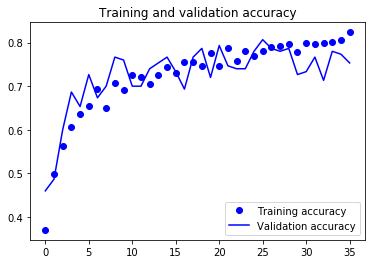

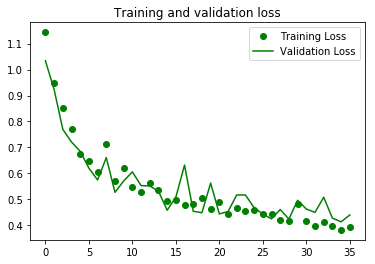

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# TEST

In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image

file_list = ['test_cat.jpg', 'test_dog.jpg', 'test_horse.jpg', 'cat.0.jpg', 'cat.1.jpg', 'cat.2.jpg', 'dog.0.jpg', 'dog.1.jpg', 'dog.2.jpg', 'horse01-0.png', 'horse06-1.png', 'horse11-9.png']

for file in file_list:   
    path = './0. Animal_Data/'+file
    img = image.load_img(path, target_size=(150,150))

    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)
    
    if max(classes[0]) == classes[0][0]:
        print(file + " is a cat. // prob: ", classes[0][0])
    elif max(classes[0]) == classes[0][1]:
        print(file + " is a dog. // prob: ", classes[0][1])
    elif max(classes[0]) == classes[0][2]:
        print(file + " is a horse. // prob: ", classes[0][2])
    
    print(classes)
    print()

test_cat.jpg is a dog. // prob:  0.99995375
[[4.6290392e-05 9.9995375e-01 0.0000000e+00]]

test_dog.jpg is a dog. // prob:  1.0
[[0. 1. 0.]]

test_horse.jpg is a dog. // prob:  1.0
[[0. 1. 0.]]

cat.0.jpg is a dog. // prob:  1.0
[[0. 1. 0.]]

cat.1.jpg is a dog. // prob:  1.0
[[0. 1. 0.]]

cat.2.jpg is a dog. // prob:  1.0
[[2.156602e-26 1.000000e+00 0.000000e+00]]

dog.0.jpg is a dog. // prob:  1.0
[[0. 1. 0.]]

dog.1.jpg is a dog. // prob:  1.0
[[0. 1. 0.]]

dog.2.jpg is a dog. // prob:  1.0
[[0. 1. 0.]]

horse01-0.png is a horse. // prob:  1.0
[[0. 0. 1.]]

horse06-1.png is a horse. // prob:  1.0
[[0. 0. 1.]]

horse11-9.png is a horse. // prob:  1.0
[[0. 0. 1.]]

